<a href="https://colab.research.google.com/github/Dee-Nwanjah/Python-Pandas-Mastery-Through-Real-Data/blob/main/5.)%20Auto_Data_Quality_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup and Sample Data creation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Create sample messy datasets for testing
def create_sample_datasets():
    # Dataset 1: Sales data with various issues
    sales_data = pd.DataFrame({
        'date': pd.date_range('2023-01-01', periods=100, freq='D'),
        'product': ['Product A', 'Product B', 'Product C', None, 'Product A'] * 20,
        'sales_amount': np.random.normal(1000, 200, 100),
        'region': ['North', 'South', 'East', 'West', ''] * 20,
        'customer_id': range(1, 101)
    })

    # Introduce data quality issues
    sales_data.loc[10:15, 'sales_amount'] = None  # Missing values
    sales_data.loc[20:25, 'sales_amount'] = -100  # Negative sales (outliers)
    sales_data.loc[30, 'date'] = None  # Missing date
    sales_data.loc[40:45, 'product'] = sales_data.loc[40:45, 'product'].str.upper()  # Inconsistent formatting

    # Add duplicates
    sales_data = pd.concat([sales_data, sales_data.iloc[0:5]], ignore_index=True)

    return sales_data

# Create sample data
df_sales = create_sample_datasets()
df_sales.to_csv('sample_sales_data.csv', index=False)

print("Sample data created with intentional quality issues:")
print(f"Shape: {df_sales.shape}")
print(df_sales.head(10))

Sample data created with intentional quality issues:
Shape: (105, 5)
        date    product  sales_amount region  customer_id
0 2023-01-01  Product A   1127.750507  North            1
1 2023-01-02  Product B   1162.997357  South            2
2 2023-01-03  Product C   1468.064259   East            3
3 2023-01-04       None   1106.532299   West            4
4 2023-01-05  Product A   1195.721412                   5
5 2023-01-06  Product A    953.218376  North            6
6 2023-01-07  Product B   1246.001794  South            7
7 2023-01-08  Product C   1130.128386   East            8
8 2023-01-09       None    844.717400   West            9
9 2023-01-10  Product A   1294.020660                  10


In [ ]:
# Build Core Data Quality Functions
def analyze_missing_data(df):
    """Analyze missing data patterns"""
    missing_info = []

    for column in df.columns:
        missing_count = df[column].isnull().sum()
        missing_percent = (missing_count / len(df)) * 100

        missing_info.append({
            'column': column,
            'missing_count': missing_count,
            'missing_percent': missing_percent,
            'data_type': str(df[column].dtype),
            'severity': 'High' if missing_percent > 20 else 'Medium' if missing_percent > 5 else 'Low'
        })

    return pd.DataFrame(missing_info)

def detect_outliers(df, numeric_columns=None):
    """Detect outliers using IQR method"""
    if numeric_columns is None:
        numeric_columns = df.select_dtypes(include=[np.number]).columns

    outliers_info = []

    for column in numeric_columns:
        if df[column].dtype in ['int64', 'float64']:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

            outliers_info.append({
                'column': column,
                'outlier_count': len(outliers),
                'outlier_percent': (len(outliers) / len(df)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            })

    return pd.DataFrame(outliers_info)

def check_duplicates(df):
    """Check for duplicate records"""
    exact_duplicates = df.duplicated().sum()

    # Check for duplicates in key columns (customize based on your data)
    partial_duplicates = {}
    for column in df.columns:
        if df[column].dtype == 'object':  # Text columns
            dup_count = df.duplicated(subset=[column], keep=False).sum()
            if dup_count > 0:
                partial_duplicates[column] = dup_count

    return {
        'exact_duplicates': exact_duplicates,
        'partial_duplicates': partial_duplicates
    }

def analyze_data_consistency(df):
    """Check for data consistency issues"""
    consistency_issues = []

    for column in df.select_dtypes(include=['object']).columns:
        # Check for case inconsistencies
        if df[column].notna().any():
            unique_values = df[column].dropna().unique()
            case_variations = {}

            for value in unique_values:
                normalized = str(value).lower().strip()
                if normalized in case_variations:
                    case_variations[normalized].append(value)
                else:
                    case_variations[normalized] = [value]

            # Find variations
            variations = {k: v for k, v in case_variations.items() if len(v) > 1}

            if variations:
                consistency_issues.append({
                    'column': column,
                    'issue_type': 'Case/Format Inconsistency',
                    'variations': variations
                })

    return consistency_issues

# Test the functions
print("=== DATA QUALITY ANALYSIS ===")
print("\n1. Missing Data Analysis:")
missing_analysis = analyze_missing_data(df_sales)
print(missing_analysis)

=== DATA QUALITY ANALYSIS ===

1. Missing Data Analysis:
         column  missing_count  missing_percent       data_type severity
0          date              1         0.952381  datetime64[ns]      Low
1       product             21        20.000000          object   Medium
2  sales_amount              6         5.714286         float64   Medium
3        region              0         0.000000          object      Low
4   customer_id              0         0.000000           int64      Low


In [ ]:
# Build Automated Report Generator
def generate_data_quality_report(df, dataset_name="Dataset"):
    """Generate comprehensive data quality report"""

    report_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Basic dataset info
    basic_info = {
        'dataset_name': dataset_name,
        'timestamp': report_timestamp,
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
    }

    # Run all quality checks
    missing_data = analyze_missing_data(df)
    outliers = detect_outliers(df)
    duplicates = check_duplicates(df)
    consistency = analyze_data_consistency(df)

    # Create comprehensive report
    report = f"""
{'='*60}
DATA QUALITY REPORT
{'='*60}
Dataset: {basic_info['dataset_name']}
Generated: {basic_info['timestamp']}

📊 BASIC STATISTICS:
- Total Rows: {basic_info['total_rows']:,}
- Total Columns: {basic_info['total_columns']:,}
- Memory Usage: {basic_info['memory_usage_mb']:.2f} MB

🚨 MISSING DATA ISSUES:
"""

    high_missing = missing_data[missing_data['severity'] == 'High']
    if len(high_missing) > 0:
        report += "  HIGH SEVERITY (>20% missing):\n"
        for _, row in high_missing.iterrows():
            report += f"    - {row['column']}: {row['missing_percent']:.1f}% missing\n"

    medium_missing = missing_data[missing_data['severity'] == 'Medium']
    if len(medium_missing) > 0:
        report += "  MEDIUM SEVERITY (5-20% missing):\n"
        for _, row in medium_missing.iterrows():
            report += f"    - {row['column']}: {row['missing_percent']:.1f}% missing\n"

    report += f"\n🎯 OUTLIERS DETECTED:\n"
    if len(outliers) > 0:
        for _, row in outliers.iterrows():
            if row['outlier_count'] > 0:
                report += f"    - {row['column']}: {row['outlier_count']} outliers ({row['outlier_percent']:.1f}%)\n"
    else:
        report += "    No significant outliers detected.\n"

    report += f"\n📋 DUPLICATE RECORDS:\n"
    report += f"    - Exact duplicates: {duplicates['exact_duplicates']}\n"
    if duplicates['partial_duplicates']:
        report += "    - Partial duplicates:\n"
        for col, count in duplicates['partial_duplicates'].items():
            report += f"      • {col}: {count} duplicated values\n"

    report += f"\n🔧 CONSISTENCY ISSUES:\n"
    if consistency:
        for issue in consistency:
            report += f"    - {issue['column']}: {issue['issue_type']}\n"
            for norm_val, variations in issue['variations'].items():
                report += f"      • '{norm_val}' appears as: {variations}\n"
    else:
        report += "    No major consistency issues detected.\n"

    # Quality score calculation
    total_issues = (
        len(missing_data[missing_data['missing_percent'] > 5]) +
        len(outliers[outliers['outlier_percent'] > 2]) +
        (1 if duplicates['exact_duplicates'] > 0 else 0) +
        len(consistency)
    )

    max_possible_issues = len(df.columns) * 3  # Rough estimate
    quality_score = max(0, 100 - (total_issues / max_possible_issues * 100))

    report += f"\n⭐ OVERALL QUALITY SCORE: {quality_score:.1f}/100\n"

    if quality_score >= 90:
        report += "✅ EXCELLENT - Data is ready for analysis\n"
    elif quality_score >= 70:
        report += "⚠️  GOOD - Minor issues that should be addressed\n"
    elif quality_score >= 50:
        report += "🚨 FAIR - Significant issues need attention\n"
    else:
        report += "❌ POOR - Major data quality problems detected\n"

    return report, {
        'basic_info': basic_info,
        'missing_data': missing_data,
        'outliers': outliers,
        'duplicates': duplicates,
        'consistency': consistency,
        'quality_score': quality_score
    }

# Generate report for our sample data
report_text, report_data = generate_data_quality_report(df_sales, "Sample Sales Data")
print(report_text)


DATA QUALITY REPORT
Dataset: Sample Sales Data
Generated: 2025-08-02 14:24:51

📊 BASIC STATISTICS:
- Total Rows: 105
- Total Columns: 5
- Memory Usage: 0.01 MB

🚨 MISSING DATA ISSUES:
  MEDIUM SEVERITY (5-20% missing):
    - product: 20.0% missing
    - sales_amount: 5.7% missing

🎯 OUTLIERS DETECTED:
    - sales_amount: 6 outliers (5.7%)

📋 DUPLICATE RECORDS:
    - Exact duplicates: 5
    - Partial duplicates:
      • product: 103 duplicated values
      • region: 105 duplicated values

🔧 CONSISTENCY ISSUES:
    - product: Case/Format Inconsistency
      • 'product a' appears as: ['Product A', 'PRODUCT A']
      • 'product b' appears as: ['Product B', 'PRODUCT B']
      • 'product c' appears as: ['Product C', 'PRODUCT C']

⭐ OVERALL QUALITY SCORE: 66.7/100
🚨 FAIR - Significant issues need attention



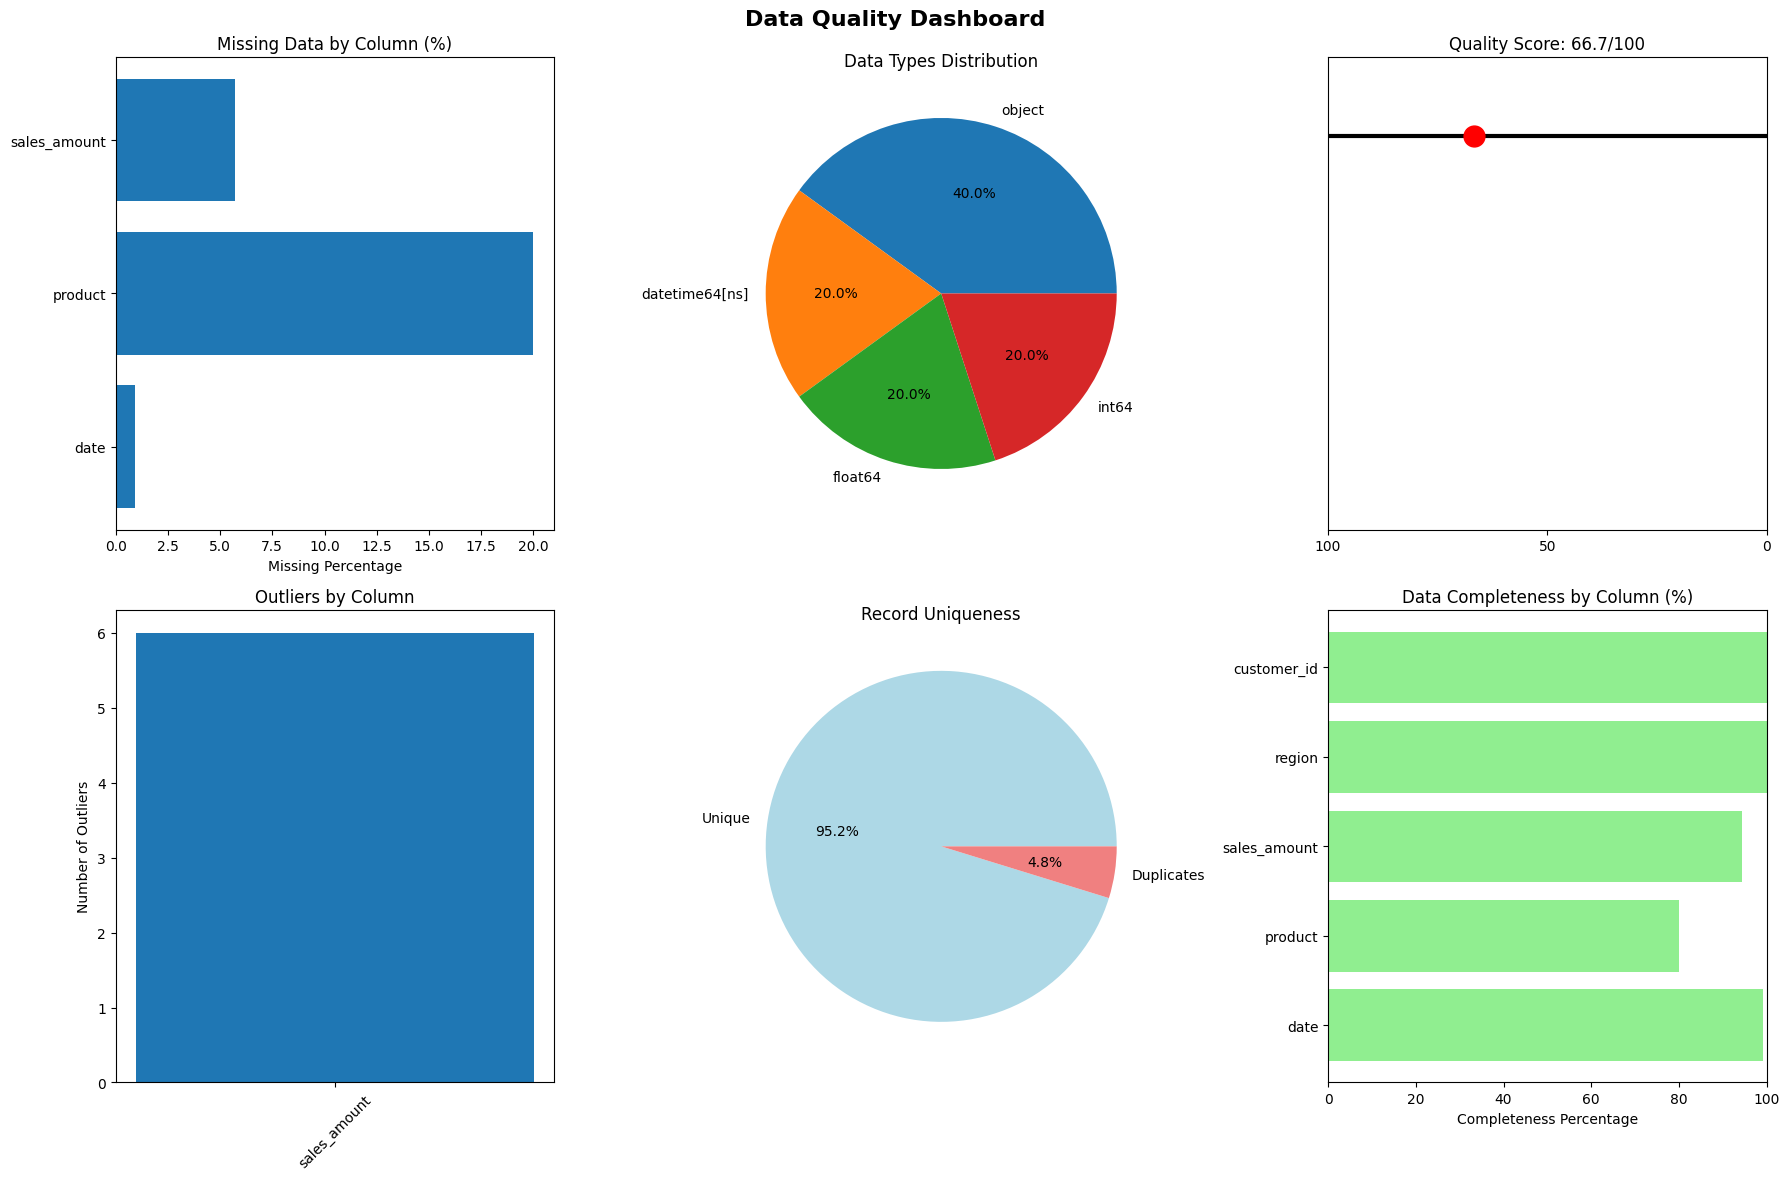

In [ ]:
# Creating Visual Data Quality Dashboard
def create_quality_dashboard(df, report_data):
    """Create visual dashboard for data quality"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Data Quality Dashboard', fontsize=16, fontweight='bold')

    # 1. Missing Data Visualization
    missing_data = report_data['missing_data']
    missing_data_filtered = missing_data[missing_data['missing_percent'] > 0]

    if len(missing_data_filtered) > 0:
        axes[0, 0].barh(missing_data_filtered['column'], missing_data_filtered['missing_percent'])
        axes[0, 0].set_title('Missing Data by Column (%)')
        axes[0, 0].set_xlabel('Missing Percentage')
    else:
        axes[0, 0].text(0.5, 0.5, 'No Missing Data', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Missing Data by Column (%)')

    # 2. Data Types Distribution
    dtype_counts = df.dtypes.value_counts()
    axes[0, 1].pie(dtype_counts.values, labels=dtype_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Data Types Distribution')

    # 3. Quality Score Gauge
    quality_score = report_data['quality_score']
    theta = np.linspace(0, np.pi, 100)
    r = np.ones_like(theta)

    axes[0, 2].plot(theta, r, 'k-', linewidth=3)
    score_angle = np.pi * (100 - quality_score) / 100
    axes[0, 2].plot([score_angle], [1], 'ro', markersize=15)
    axes[0, 2].set_ylim(0, 1.2)
    axes[0, 2].set_xlim(0, np.pi)
    axes[0, 2].set_title(f'Quality Score: {quality_score:.1f}/100')
    axes[0, 2].set_yticks([])
    axes[0, 2].set_xticks([0, np.pi/2, np.pi])
    axes[0, 2].set_xticklabels(['100', '50', '0'])

    # 4. Outliers by Column
    outliers_data = report_data['outliers']
    if len(outliers_data) > 0 and outliers_data['outlier_count'].sum() > 0:
        outliers_filtered = outliers_data[outliers_data['outlier_count'] > 0]
        axes[1, 0].bar(outliers_filtered['column'], outliers_filtered['outlier_count'])
        axes[1, 0].set_title('Outliers by Column')
        axes[1, 0].set_ylabel('Number of Outliers')
        axes[1, 0].tick_params(axis='x', rotation=45)
    else:
        axes[1, 0].text(0.5, 0.5, 'No Outliers', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Outliers by Column')

    # 5. Record Count and Duplicates
    total_records = len(df)
    duplicates = report_data['duplicates']['exact_duplicates']
    unique_records = total_records - duplicates

    axes[1, 1].pie([unique_records, duplicates], labels=['Unique', 'Duplicates'],
                   autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    axes[1, 1].set_title('Record Uniqueness')

    # 6. Completeness by Column
    completeness = 100 - missing_data['missing_percent']
    axes[1, 2].barh(missing_data['column'], completeness, color='lightgreen')
    axes[1, 2].set_title('Data Completeness by Column (%)')
    axes[1, 2].set_xlabel('Completeness Percentage')
    axes[1, 2].set_xlim(0, 100)

    plt.tight_layout()
    plt.show()

# Create dashboard
create_quality_dashboard(df_sales, report_data)

In [ ]:
# An Automated Monitoring System
def save_quality_report(report_text, report_data, filename_prefix="data_quality"):
    """Save comprehensive quality reports"""

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save text report
    text_filename = f"{filename_prefix}_report_{timestamp}.txt"
    with open(text_filename, 'w') as f:
        f.write(report_text)

    # Save detailed data to CSV
    csv_filename = f"{filename_prefix}_details_{timestamp}.csv"

    # Combine all analyses into one DataFrame
    summary_data = []

    # Add missing data info
    for _, row in report_data['missing_data'].iterrows():
        summary_data.append({
            'check_type': 'Missing Data',
            'column': row['column'],
            'issue_count': row['missing_count'],
            'severity': row['severity'],
            'percentage': row['missing_percent']
        })

    # Add outlier info
    for _, row in report_data['outliers'].iterrows():
        if row['outlier_count'] > 0:
            summary_data.append({
                'check_type': 'Outliers',
                'column': row['column'],
                'issue_count': row['outlier_count'],
                'severity': 'Medium' if row['outlier_percent'] > 5 else 'Low',
                'percentage': row['outlier_percent']
            })

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(csv_filename, index=False)

    print(f"📄 Reports saved:")
    print(f"  - Text report: {text_filename}")
    print(f"  - Detailed data: {csv_filename}")

    return text_filename, csv_filename

# Save the reports
text_file, csv_file = save_quality_report(report_text, report_data, "sample_sales_data_quality")

📄 Reports saved:
  - Text report: sample_sales_data_quality_report_20250802_142844.txt
  - Detailed data: sample_sales_data_quality_details_20250802_142844.csv
